
# 🎬 Netflix Data — Cleaning, Analysis & Visualization 

**Internship:** Unified Mentor  
**Author:** Vaibhav Parmar  
**Goal:** Clean the Netflix dataset and explore it with simple, clear visualizations.




## 🚀 How to Use This Notebook
1. Put your Netflix CSV (commonly `netflix_titles.csv`) in the **same folder** as this notebook.  
2. If your CSV name is different, update the `CSV_FILE` value below.  
3. Run all cells: _Runtime → Run all_.  
4. Check the `outputs/` folder for cleaned data, figures, and small summary tables.


In [3]:

# --- Imports & Configuration ---
import os
import sys
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Show more columns/rows if needed
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

# --- Config (edit these if needed) ---
CSV_FILE = "netflix_titles.csv"  # TODO: If your file has a different name, change it here.
FIG_DIR = os.path.join("outputs", "figures")
DATA_DIR = os.path.join("outputs", "data")
SAVE_FIGS = True  # Set to False if you do not want to save PNGs

# Create output folders
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

def savefig(path: str):
    """Save current matplotlib figure safely with tight layout."""
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches='tight')
    print(f"[Saved figure] {path}")



## 📥 Load the Dataset
If the CSV is not found, the notebook will show an error with a simple message.


In [4]:

# Try to load the CSV file
if not os.path.exists(CSV_FILE):
    print(f"[Error] CSV file not found: {CSV_FILE}")
    print("-> Put your CSV in the same folder and update CSV_FILE above if needed.")
    raise SystemExit

df = pd.read_csv(CSV_FILE)
print("First 5 rows:")
display(df.head())
print("\nBasic info:")
print(df.info())


First 5 rows:


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"



Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB
None



## 🧼 Basic Cleaning
Simple, safe cleaning steps that keep the data usable and honest.


In [5]:

# 1) Standardize column names (lowercase + underscores)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# 2) Remove exact duplicate rows (if any)
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Removed duplicates: {before - after}")

# 3) Trim spaces in text columns
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()

# 4) Fill some important text columns with 'Unknown' instead of blank
for col in ["director", "cast", "country", "rating"]:
    if col in df.columns:
        df[col] = df[col].replace({np.nan: "Unknown"})
        df[col] = df[col].replace({"": "Unknown"})

display(df.head())


Removed duplicates: 0


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"



## 🗓️ Dates and Extra Helper Columns
- Convert `date_added` to a proper date.  
- Create `year_added` and `month_added`.  
- Parse `duration` into minutes for Movies and seasons for TV Shows.


In [6]:

# Convert date_added to datetime (if present)
if "date_added" in df.columns:
    df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
    df["year_added"] = df["date_added"].dt.year
    df["month_added"] = df["date_added"].dt.month

# Parse duration into minutes or seasons
def parse_duration_minutes(value: str):
    text = str(value).lower()
    if "min" in text:
        import re
        m = re.findall(r"(\d+)\s*min", text)
        return int(m[0]) if m else np.nan
    return np.nan

def parse_seasons(value: str):
    text = str(value).lower()
    if "season" in text:
        import re
        m1 = re.findall(r"(\d+)\s*season", text)      # handles '1 Season'
        m2 = re.findall(r"(\d+)\s*seasons", text)     # handles '2 Seasons'
        # prefer m1 if present; otherwise m2
        if m1:
            return int(m1[0])
        if m2:
            return int(m2[0])
    return np.nan

if "duration" in df.columns:
    df["duration_minutes"] = df["duration"].apply(parse_duration_minutes)
    df["seasons"] = df["duration"].apply(parse_seasons)

# Split genres (listed_in) to a simple list for counting
if "listed_in" in df.columns:
    df["genres_list"] = df["listed_in"].astype(str).apply(lambda x: [g.strip() for g in x.split(",")])

display(df.head())


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,year_added,month_added,duration_minutes,seasons,genres_list
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,2021,9,90.0,NaN,[Documentaries]
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",2021,9,NaN,1.0,"[Crime TV Shows, International TV Shows, TV Ac..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",2021,9,NaN,1.0,"[TV Dramas, TV Horror, TV Mysteries]"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",2021,9,91.0,NaN,"[Children & Family Movies, Comedies]"
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",2021,9,125.0,NaN,"[Dramas, Independent Movies, International Mov..."



## 💾 Save Cleaned Dataset
The cleaned CSV is useful for your report and any further analysis.


In [7]:

clean_path = os.path.join(DATA_DIR, "netflix_cleaned.csv")
df.to_csv(clean_path, index=False)
print(f"[Saved cleaned data] {clean_path}")


[Saved cleaned data] outputs\data\netflix_cleaned.csv



## 📊 Quick Summary
A short look at dataset size, content types, and ratings.


In [8]:

print("Total rows:", len(df))

if "type" in df.columns:
    print("\nMovies vs TV Shows:")
    display(df["type"].value_counts())

if "rating" in df.columns:
    print("\nTop Ratings:")
    display(df["rating"].value_counts().head(12))


Total rows: 8790

Movies vs TV Shows:


type
Movie      6126
TV Show    2664
Name: count, dtype: int64


Top Ratings:


rating
TV-MA       3205
TV-14       2157
TV-PG        861
R            799
PG-13        490
TV-Y7        333
TV-Y         306
PG           287
TV-G         220
NR            79
G             41
TV-Y7-FV       6
Name: count, dtype: int64


# 📈 Visualizations 

> Each chart uses Matplotlib and is saved to `outputs/figures/`.  
> No special styles, no complex settings — just clean, readable plots.


In [9]:

def bar_plot_from_series(series, title, xlabel, ylabel, rotate=0, filename=None):
    s = series.dropna()
    plt.figure(figsize=(10, 5))
    s.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if rotate:
        plt.xticks(rotation=rotate, ha="right")
    if SAVE_FIGS and filename:
        savefig(os.path.join(FIG_DIR, filename))
    plt.show()

def simple_line(x, y, title, xlabel, ylabel, filename=None):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, marker="o")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if SAVE_FIGS and filename:
        savefig(os.path.join(FIG_DIR, filename))
    plt.show()



## 1) Movies vs TV Shows


[Saved figure] outputs\figures\type_counts.png


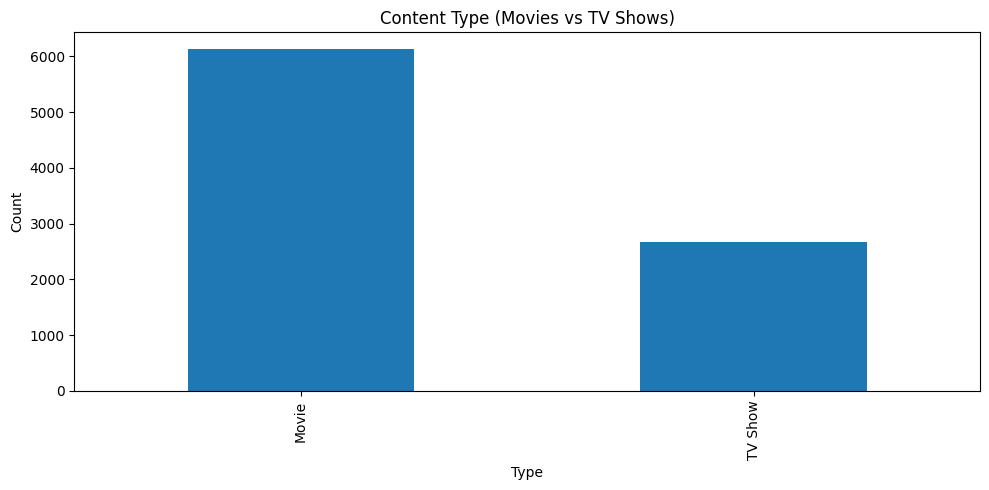

In [10]:

if "type" in df.columns:
    type_counts = df["type"].value_counts()
    bar_plot_from_series(type_counts, "Content Type (Movies vs TV Shows)", "Type", "Count",
                         filename="type_counts.png")
else:
    print("Column 'type' not found.")



## 2) Ratings Distribution (Top 12)


[Saved figure] outputs\figures\ratings_top12.png


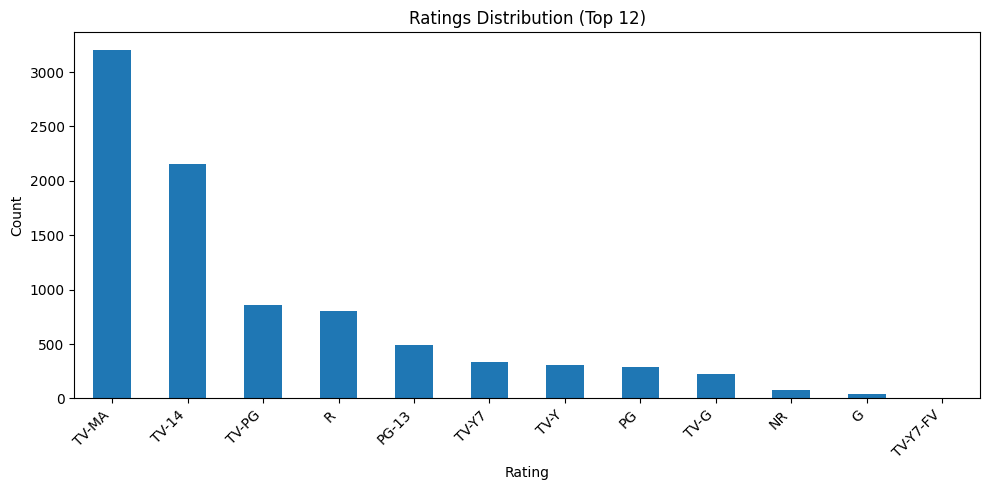

In [11]:

if "rating" in df.columns:
    rating_counts = df["rating"].value_counts().head(12)
    bar_plot_from_series(rating_counts, "Ratings Distribution (Top 12)", "Rating", "Count",
                         rotate=45, filename="ratings_top12.png")
else:
    print("Column 'rating' not found.")



## 3) Titles Added Per Year


[Saved figure] outputs\figures\titles_per_year.png


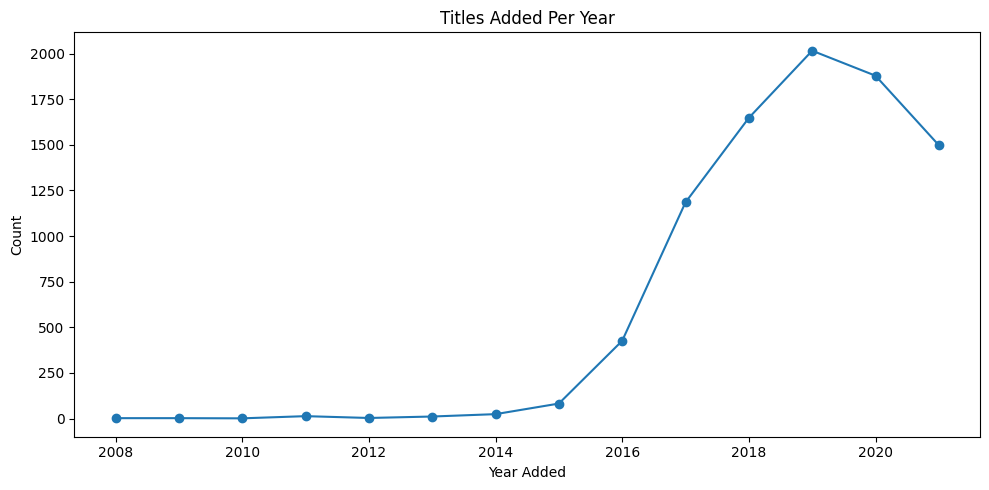

In [12]:

if "year_added" in df.columns:
    ya = df["year_added"].dropna().astype(int).value_counts().sort_index()
    simple_line(ya.index, ya.values, "Titles Added Per Year", "Year Added", "Count",
                filename="titles_per_year.png")
else:
    print("Column 'year_added' not available. Make sure 'date_added' existed and parsed.")



## 4) Top Countries (by first country listed)


[Saved figure] outputs\figures\top_countries.png


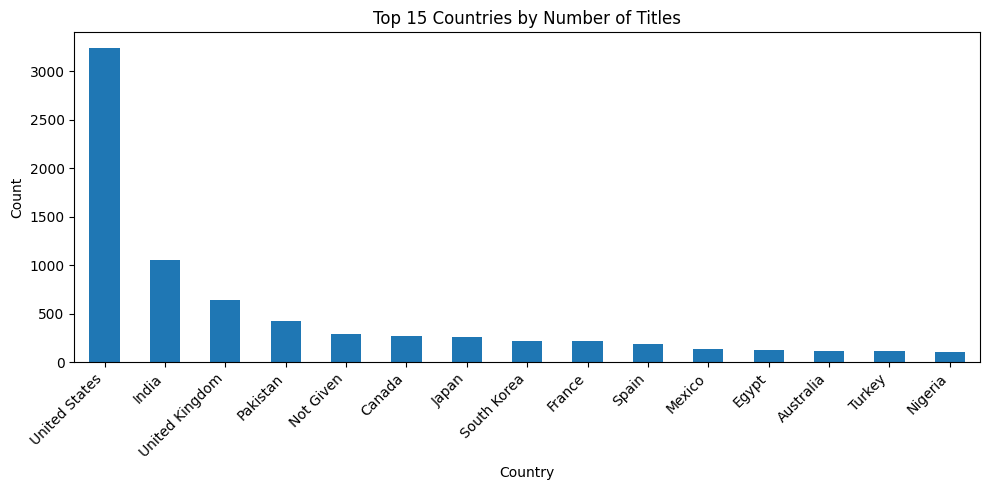

In [13]:

if "country" in df.columns:
    first_country = df["country"].astype(str).apply(lambda x: x.split(",")[0].strip() if x != "Unknown" else "Unknown")
    country_counts = first_country.value_counts().head(15)
    bar_plot_from_series(country_counts, "Top 15 Countries by Number of Titles", "Country", "Count",
                         rotate=45, filename="top_countries.png")
else:
    print("Column 'country' not found.")



## 5) Top Genres


[Saved figure] outputs\figures\top_genres.png


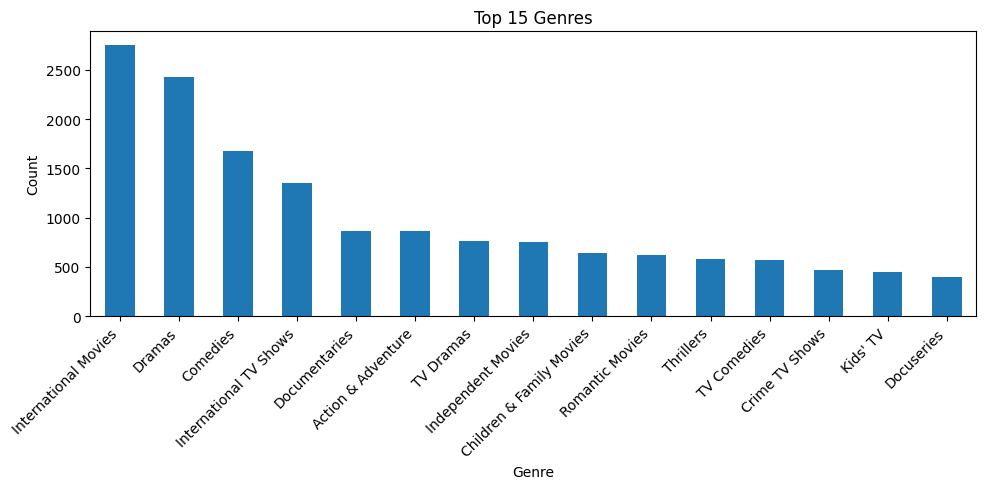

In [14]:

if "genres_list" in df.columns:
    all_genres = []
    for lst in df["genres_list"]:
        all_genres.extend(lst)
    import pandas as pd
    from collections import Counter
    genres_series = pd.Series(Counter(all_genres)).sort_values(ascending=False)
    bar_plot_from_series(genres_series.head(15), "Top 15 Genres", "Genre", "Count",
                         rotate=45, filename="top_genres.png")
else:
    print("Column 'listed_in' not found (needed to create 'genres_list').")



## 6) Top Directors


[Saved figure] outputs\figures\top_directors.png


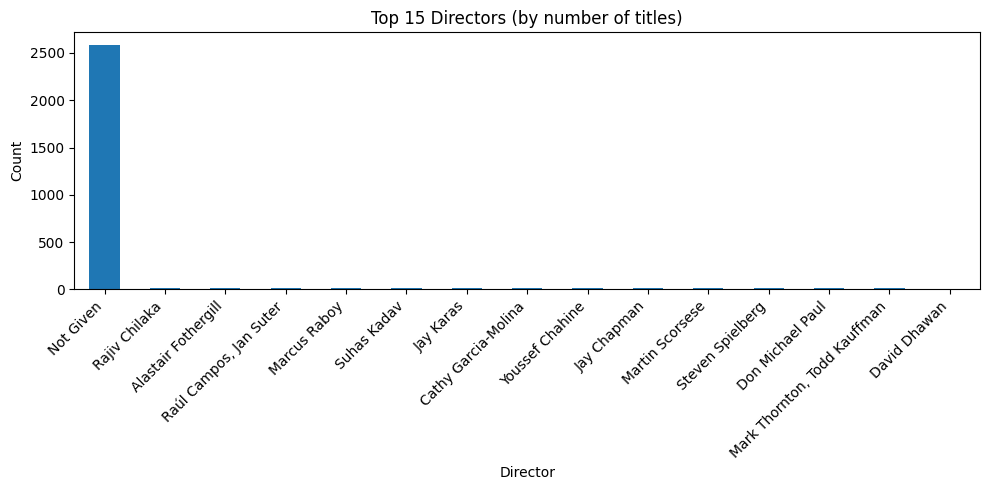

In [15]:

if "director" in df.columns:
    directors = df[df["director"].str.lower() != "unknown"]["director"].value_counts().head(15)
    if len(directors) > 0:
        bar_plot_from_series(directors, "Top 15 Directors (by number of titles)", "Director", "Count",
                             rotate=45, filename="top_directors.png")
    else:
        print("No directors found after filtering unknown.")
else:
    print("Column 'director' not found.")



## 7) Top Actors


In [16]:

if "cast" in df.columns:
    actor_counter = Counter()
    for row in df["cast"].dropna():
        if isinstance(row, str) and row.lower() != "unknown":
            for a in row.split(","):
                actor_counter[a.strip()] += 1
    import pandas as pd
    top_actors = pd.Series(actor_counter).sort_values(ascending=False).head(20)
    if len(top_actors) > 0:
        bar_plot_from_series(top_actors, "Top 20 Actors", "Actor", "Count",
                             rotate=45, filename="top_actors.png")
    else:
        print("No actors to display.")
else:
    print("Column 'cast' not found.")


Column 'cast' not found.



## 8) Release Year Trend by Type


[Saved figure] outputs\figures\release_year_trend_by_type.png


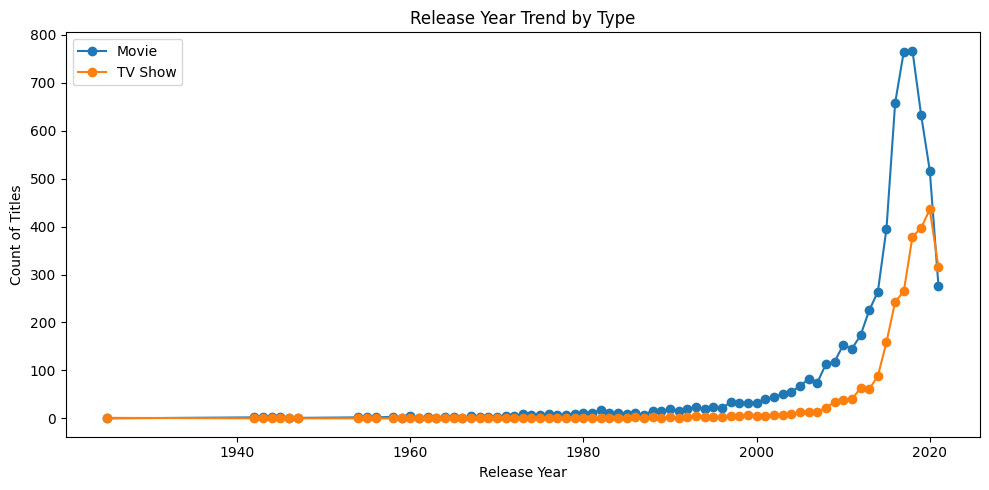

In [17]:

if "release_year" in df.columns and "type" in df.columns:
    pivot = df.pivot_table(index="release_year", columns="type", values="show_id", aggfunc="count").fillna(0)
    plt.figure(figsize=(10, 5))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker="o", label=col)
    plt.title("Release Year Trend by Type")
    plt.xlabel("Release Year")
    plt.ylabel("Count of Titles")
    plt.legend()
    if SAVE_FIGS:
        savefig(os.path.join(FIG_DIR, "release_year_trend_by_type.png"))
    plt.show()
else:
    print("Required columns 'release_year' and/or 'type' not found.")



## 🧾 Export Key Tables (for your report)
These small tables are saved as CSV so you can quote numbers easily.


In [18]:

summary_tables = {}

if "type" in df.columns:
    summary_tables["type_counts.csv"] = df["type"].value_counts()

if "rating" in df.columns:
    summary_tables["rating_top12.csv"] = df["rating"].value_counts().head(12)

if "year_added" in df.columns:
    summary_tables["titles_per_year.csv"] = df["year_added"].dropna().astype(int).value_counts().sort_index()

if "country" in df.columns:
    first_country = df["country"].astype(str).apply(lambda x: x.split(",")[0].strip() if x != "Unknown" else "Unknown")
    summary_tables["top_countries.csv"] = first_country.value_counts().head(20)

if "genres_list" in df.columns:
    # uses genres_series if available, otherwise recompute
    if 'genres_series' in globals():
        summary_tables["top_genres.csv"] = genres_series.head(30)
    else:
        all_genres = []
        for lst in df["genres_list"]:
            all_genres.extend(lst)
        import pandas as pd
        from collections import Counter
        tmp = pd.Series(Counter(all_genres)).sort_values(ascending=False)
        summary_tables["top_genres.csv"] = tmp.head(30)

if "director" in df.columns:
    summary_tables["top_directors.csv"] = df[df["director"].str.lower() != "unknown"]["director"].value_counts().head(30)

if "cast" in df.columns:
    if 'top_actors' in globals():
        summary_tables["top_actors.csv"] = top_actors
    else:
        summary_tables["top_actors.csv"] = pd.Series(dtype=int)

for fname, series in summary_tables.items():
    out = os.path.join(DATA_DIR, fname)
    series.to_csv(out, header=["count"])
    print(f"[Saved table] {out}")


[Saved table] outputs\data\type_counts.csv
[Saved table] outputs\data\rating_top12.csv
[Saved table] outputs\data\titles_per_year.csv
[Saved table] outputs\data\top_countries.csv
[Saved table] outputs\data\top_genres.csv
[Saved table] outputs\data\top_directors.csv



# 📝 Insights:-

After exploring the Netflix dataset, I found that Movies are more common than TV Shows on the platform. This means Netflix still releases more films overall compared to series, though both have a strong presence.

In terms of content ratings, I noticed that TV-MA and TV-14 appear the most. These ratings usually represent content meant for mature audiences or teenagers, which suggests Netflix has a lot of content aimed at older viewers rather than small kids.

When checking which countries contribute the most titles, the United States is clearly at the top. Following that, countries like India, United Kingdom, and Canada also produce a large amount of Netflix content, showing that Netflix’s library is quite global.

The most common genres I found were Documentaries, Dramas, and Comedies. These genres appear very frequently, which makes sense because they appeal to a wide audience and Netflix invests heavily in them.

Looking at yearly trends, the number of titles on Netflix has grown a lot over the years, especially after 2015. This shows that Netflix has expanded its content library rapidly in recent years to grow its user base.

Overall, Netflix seems to focus heavily on mature content, and most of its library consists of movies, with strong representation from countries like the US and India.

